# Introduction

The contact distance features have too many features for TICA to sensibly cope with.  So I'm removing the bottom ranked features in terms of their lagged autocorrelation. I'll be combining the trajectories of the reactant and transition state. The cutoff will be a lagged autocorrelation of $1^2$ Angstroms. In otherwords if a contact is larger than its mean value by 1 Angstrom, then we only keep those features which at a time later have only decreased to 1 Angstrom above the mean or greater. 

In [76]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from pyemma.coordinates import covariance_lagged

In [77]:
sim_names = ['transition_state', 'reactant']

In [78]:
sim_name = sim_names[0]
f_traj_paths = glob(f'{sim_names[0]}/features/contact/*.npy') + glob(f'{sim_names[1]}/features/contact/*.npy')
f_trajs = [np.load(x) for x in f_traj_paths]

In [79]:
def high_cov_features(lag, f_trajs):
    if lag == 0:
        c0t = False
    else:
        c0t = True
    cov = covariance_lagged(f_trajs, lag=lag, c0t = c0t, remove_data_mean=True)
    to_ang = 10
    cutoff = 1
    if lag == 0:
        ix = np.sqrt(np.diag(cov.C00_))*to_ang  > cutoff
    else:
        ix = np.sqrt(np.diag(cov.C0t_))*to_ang  > cutoff
    
    return ix

In [80]:
lags = (np.arange(0, 11, 1)*10).astype(int)
num_features_retained = np.empty(lags.shape[0])
for i, lag in enumerate(lags):
    ix = high_cov_features(lag, f_trajs)
    num_features_retained[i] = np.sum(ix)


100%|██████████| 38/38 [00:41<00:00,  1.10s/it]                       


(0.0, 3600.0)

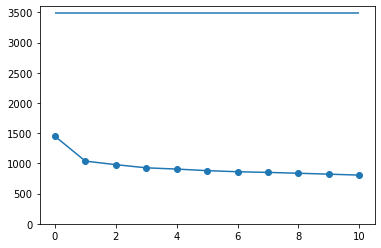

In [81]:
plt.hlines(f_trajs[0].shape[1], 0, lags[-1]/10)
plt.plot(lags/10, num_features_retained, marker='o')
plt.ylim(0, 3600)

As the cutoff concept is a bit unintuitive let's look at some of the high cov and low cov features at a lag of 1ns


In [82]:
cov = covariance_lagged(f_trajs, lag=10, c0t = True, remove_data_mean=True)

100%|██████████| 38/38 [00:44<00:00,  1.17s/it]                       


In [83]:
ac = np.sqrt(np.diag(cov.C0t_))

In [86]:
sorted_ix = np.argsort(ac)
high_feat = sorted_ix[-1]
mid_feat = sorted_ix[int(sorted_ix.shape[0]//2)]
low_feat = sorted_ix[0]

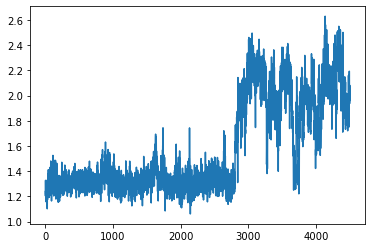

In [88]:
plt.plot(f_trajs[0][:, high_feat])

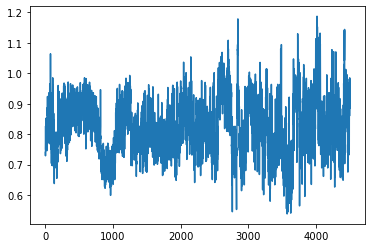

In [89]:
plt.plot(f_trajs[0][:, mid_feat])

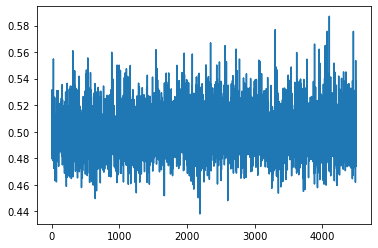

In [90]:
plt.plot(f_trajs[0][:, low_feat])

In [91]:
keep_ix = high_cov_features(lag=10, f_trajs=f_trajs)

100%|██████████| 38/38 [00:43<00:00,  1.14s/it]                       


In [92]:
f_traj_filtered_paths = [x.replace('contact', 'contact_filtered') for x in f_traj_paths]

In [96]:
for i in range(len(f_traj_filtered_paths)):
    np.save(file=f_traj_filtered_paths[i], arr=f_trajs[i][:, keep_ix])